In [1]:
import pandas as pd
import numpy as np
import urllib.request
import datetime
from os.path import join
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpltPath
from shapely.geometry import Polygon
from collections import Counter
from scipy.ndimage.filters import gaussian_filter
import scipy
import pickle5 as pickle
import seaborn as sns
from hwtmode.evaluation import find_coord_indices, combine_storm_reports, generate_obs_grid

2021-10-04 16:12:58.810615: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [11]:
import pandas as pd
import os

In [26]:
(pd.Timestamp("today", tz="UTC") - pd.Timedelta(hours=3)).strftime("%Y%m%d-%H00")

'20211005-1600'

In [36]:
pd.date_range("20210521", "today", tz="UTC", freq='D')

DatetimeIndex(['2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00',
               '2021-05-23 00:00:00+00:00', '2021-05-24 00:00:00+00:00',
               '2021-05-25 00:00:00+00:00', '2021-05-26 00:00:00+00:00',
               '2021-05-27 00:00:00+00:00', '2021-05-28 00:00:00+00:00',
               '2021-05-29 00:00:00+00:00', '2021-05-30 00:00:00+00:00',
               ...
               '2021-09-26 00:00:00+00:00', '2021-09-27 00:00:00+00:00',
               '2021-09-28 00:00:00+00:00', '2021-09-29 00:00:00+00:00',
               '2021-09-30 00:00:00+00:00', '2021-10-01 00:00:00+00:00',
               '2021-10-02 00:00:00+00:00', '2021-10-03 00:00:00+00:00',
               '2021-10-04 00:00:00+00:00', '2021-10-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=138, freq='D')

In [35]:
pd.date_range("20210521", "today", tz="UTC", freq='D', closed='left')

DatetimeIndex(['2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00',
               '2021-05-23 00:00:00+00:00', '2021-05-24 00:00:00+00:00',
               '2021-05-25 00:00:00+00:00', '2021-05-26 00:00:00+00:00',
               '2021-05-27 00:00:00+00:00', '2021-05-28 00:00:00+00:00',
               '2021-05-29 00:00:00+00:00', '2021-05-30 00:00:00+00:00',
               ...
               '2021-09-26 00:00:00+00:00', '2021-09-27 00:00:00+00:00',
               '2021-09-28 00:00:00+00:00', '2021-09-29 00:00:00+00:00',
               '2021-09-30 00:00:00+00:00', '2021-10-01 00:00:00+00:00',
               '2021-10-02 00:00:00+00:00', '2021-10-03 00:00:00+00:00',
               '2021-10-04 00:00:00+00:00', '2021-10-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=138, freq='D')

In [12]:
os.listdir('/glade/scratch/cbecker/HRRR_objects/HRRR_AWS_realtime_test_20211005/')

FileNotFoundError: [Errno 2] No such file or directory: '/glade/scratch/cbecker/HRRR_objects/HRRR_AWS_realtime_test_20211005/'

In [6]:

config = dict(run_start_date="today", run_end_date="today")
for d in pd.date_range(config["run_start_date"], config['run_end_date'], freq='h'):
    print(d)
    date = (pd.Timestamp(d, tz="UTC")).strftime("%Y%m%d-%H00")
    print(date)

2021-10-05 11:52:38.990752
20211005-1100


In [8]:
date + date

'20211005-110020211005-1100'

### This function of this notebook is to:
1. Download Storm Prediction Center storm reports (Tornado, Wind, Hail) for a specified period
2. Create an aggregated hourly spatial map of all storm reports and store as a netCDF file
3. Create an aggregated hourly spatial map of all storm objects classified by either a supervised CNN or a semi-supervised GMM and store as a netCDF file

In [1]:
def generate_storm_grid(beg, end, label_path, model, model_grid_path, min_lead_time, max_lead_time, run_date_freq='1h', thresh=None, contour_level=0.02):
    """
    Generate Xarray dataset (Time, x, y) of predicted storms by a specific model. Each mode is stored as a seperate variable. Valid time is separted by hour. Minimum and maximum 
    lead times are used for ensembled HRRR runs.
    Args:
        beg (str): Beginning of date range (format: YYMMDDhhmm)
        end (str): End of date range (format: YYMMDDhhmm)
        label_path: Path to labels/ predictions
        model: Model name (encoded into label files)
        model_grid_path: Path to coarse grid 
        min_lead_time: Minimum leadtime for overlapping ensembles produced by HRRR
        max_lead_time: Maximum lead time for over lapping ensembled produced by HRRR
        run_date_freq: Frequency spacing of model run times ('{X}h', '{x}d', ...)  
    Returns:
        Xarray dataset (Time, x, y) of storm object counts. Different modes represented as variables.
    """
    
    storm_grid = xr.open_dataset(model_grid_path)
    dates = pd.date_range(pd.Timestamp(beg) - pd.Timedelta(hours=max_lead_time), pd.Timestamp(end) - pd.Timedelta(hours=min_lead_time), freq=run_date_freq)
    valid_dates = pd.date_range(pd.Timestamp(beg) + pd.Timedelta(hours=1), pd.Timestamp(end), freq='1h')
    df_storms, storm_indxs = {}, {}
    df_list, ds_list = [], []
    for date in dates:
        file_string = join(label_path, f"{model}_labels_{date.strftime('%Y%m%d-%H00')}.parquet")
        try:
            df = pd.read_parquet(file_string)
        except:
            print(f"{file_string} doesn't seem to exist. Skipping.")
            continue

        df_list.append(df[(df['time'] >= pd.Timestamp(beg)) & (df['time'] <= pd.Timestamp(end))])
        
    d = pd.concat(df_list)
    
    for valid_date in valid_dates:
        d_sub = d[d['time'] == valid_date]
        ds = storm_grid.expand_dims('time').assign_coords(valid_time=('time', [valid_date]))
        
        for storm_type in ['Disorganized' ,'QLCS', 'Supercell']:
            
            if thresh == None:
                df_storms[storm_type] = d_sub[d_sub['label'] == storm_type]
            else:
                df_storms[storm_type] = d_sub[d_sub[f'{storm_type}_prob'] >= thresh]
            
            storm_indxs[storm_type] = find_coord_indices(ds['lon'].values,
                                             ds['lat'].values,
                                             df_storms[storm_type]['centroid_lon'],
                                             df_storms[storm_type]['centroid_lat'])
            ds[storm_type] = ds['lat'] * 0
            ds[f'{storm_type}_bin'] = ds['lat'] * 0
            for i in storm_indxs[storm_type]:
                ds[storm_type][i[0], i[1]] += 1
            ds[f'{storm_type}_bin'].values = np.where(ds[storm_type] >= 1, 1, 0).astype('float32')

            ds = compute_neighborhood_prob(ds, storm_type)
            ds = add_contour_counts(ds, storm_type, contour_level=contour_level)
            
        ds_list.append(ds)
    
    ds_all = xr.concat(ds_list, dim='time')
    ds_all.attrs['Probability threshold'] = str(thresh)
    ds_all.attrs['Neighborhood Prob'] = contour_level

    return ds_all 


def compute_neighborhood_prob(ds, var, sigma=1, use_binary=True):
    """
    Compute neighborhood probabilities using a gaussian filter on a binary grid of storm locations.
    Args:
        ds (xarray dataset): Dataset containing binary grid of storm locations
        var (str): Variable to compute
        sigma: Sigma for gaussian filter (smaller will make tighter contours)
    Returns: Xarray with additional variable containing neighborhood probabilitites
    """
    if use_binary:
        ds[f'{var}_bin'] = ds[f'{var}_bin'].expand_dims('time')
        ds[f'{var}_SSPF'] = ds[f'{var}_bin'].groupby('time').apply(gaussian_filter, sigma=sigma)
    else:
        ds[var] = ds[var].expand_dims('time')
        ds[f'{var}_SSPF'] = ds[var].groupby('time').apply(gaussian_filter, sigma=sigma)
        
    return ds


def add_contour_counts(data, var, contour_level=0.02):
    """
    Find locations where neighborhood probability exceed threshhold and add as separate variable.
    Args:
        data (xarray dataset): Dataset containing neighborhood probabilities
        var (str): Variable to compute
        contour_level: Neighborhood probability threshold (defualts to 0.02 which is what SPC uses)
    Returns: Xarray with additional variable containing locations within threshold
    """
    data[f'{var}_{int(contour_level * 100)}%'] = data[f'{var}_SSPF']
    data[f'{var}_{int(contour_level * 100)}%'].values = np.where(data[f'{var}_SSPF'] >= contour_level, 1, 0)
    
    return data

In [6]:
%%time 
# Date format = 'YYYMMDDhhmm'

NWP_model = 'HRRR'
start_date = '202104280000' 
end_date = '202106040000'
# label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
label_path = f'/glade/scratch/cbecker/HWT_HRRR_rerun/labels/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'

obs = generate_obs_grid(start_date, end_date, storm_report_path, model_grid_path)
cnn_storms_hourly = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 18, '1h', None)
gmm_storms_hourly = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 18, '1h', None)

CPU times: user 3min 52s, sys: 4.38 s, total: 3min 56s
Wall time: 5min 5s


In [18]:
%%time 
# Date format = 'YYYMMDDhhmm'

NWP_model = 'HRRR'
start_date = '202104280000' 
end_date = '202106040000'
# label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
label_path = f'/glade/scratch/cbecker/HWT_HRRR_rerun/labels/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'

cnn_storms_daily = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 24, '1d', None)
gmm_storms_daily= generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 24, '1d', None)

CPU times: user 1min 3s, sys: 1.25 s, total: 1min 4s
Wall time: 1min 7s


In [37]:
%%time 
# Date format = 'YYYMMDDhhmm'

NWP_model = 'WRF'
start_date = '202104280000' 
end_date = '202106040000'
label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'

cnn_storms_daily_WRF = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 24, '1d', None)
gmm_storms_daily_WRF = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 24, '1d', None)

CPU times: user 1min 4s, sys: 1.19 s, total: 1min 5s
Wall time: 1min 7s


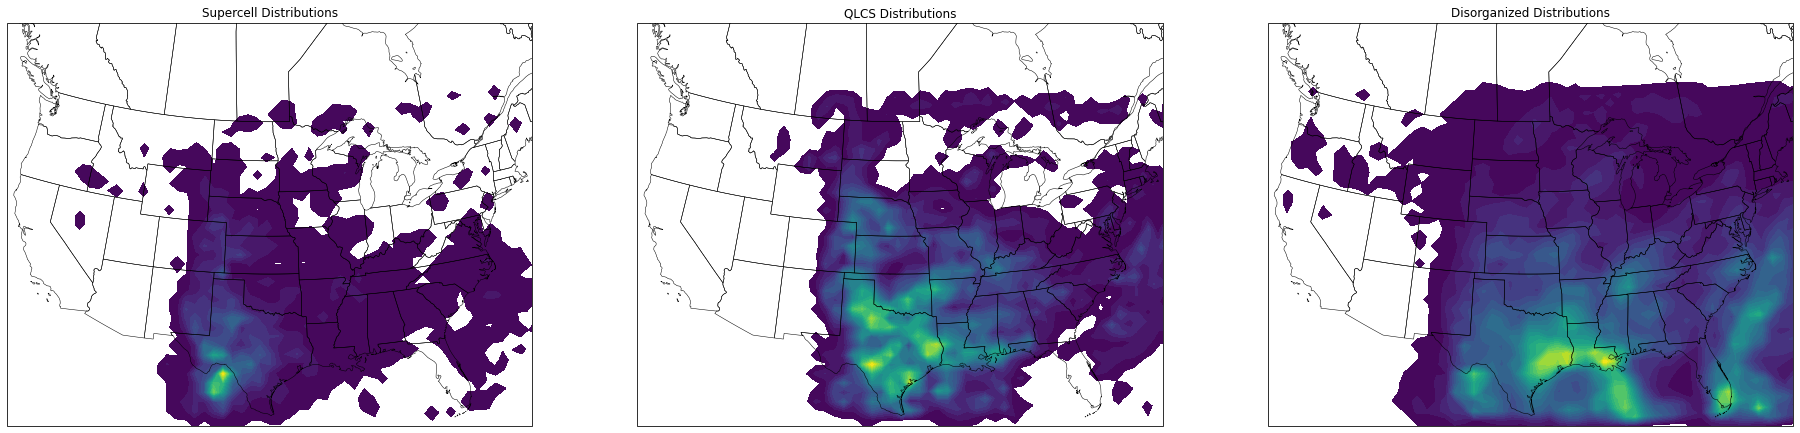

In [38]:
# Quick Sanity Check - Model Predictions

lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axes = plt.subplots(1, 3, figsize=(32, 22), subplot_kw=dict(projection=lc))
modes = ['Supercell', 'QLCS', 'Disorganized']
for i, ax in enumerate(axes.ravel()):
    mode = modes[i]
    data = cnn_storms_hourly[mode].sum(dim='time')
    ax.set_extent([-120, -75, 25, 55], crs=ccrs.PlateCarree())
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.contourf(cnn_storms_hourly.lon, cnn_storms_hourly.lat, data, levels=np.linspace(1, data.max(), 25), transform=ccrs.PlateCarree())
    ax.set_title(f'{mode} Distributions')

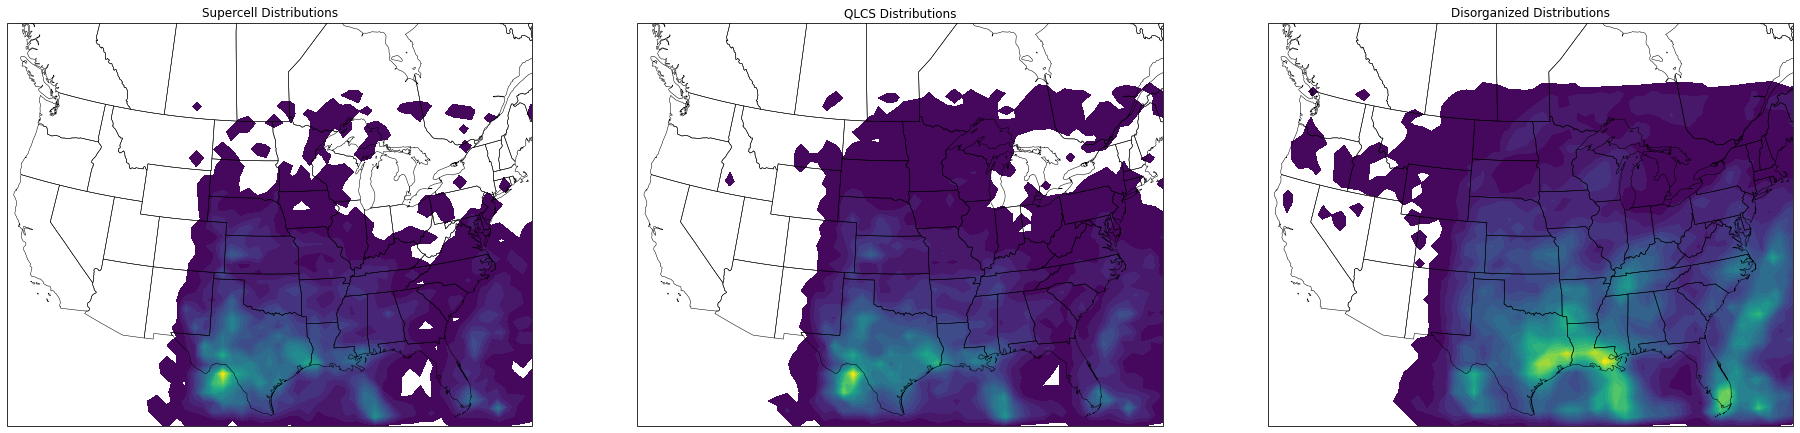

In [39]:
# Quick Sanity Check - Model Predictions

lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axes = plt.subplots(1, 3, figsize=(32, 22), subplot_kw=dict(projection=lc))
modes = ['Supercell', 'QLCS', 'Disorganized']
for i, ax in enumerate(axes.ravel()):
    mode = modes[i]
    data = gmm_storms_hourly[mode].sum(dim='time')
    ax.set_extent([-120, -75, 25, 55], crs=ccrs.PlateCarree())
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.contourf(gmm_storms_hourly.lon, gmm_storms_hourly.lat, data, levels=np.linspace(1, data.max(), 25), transform=ccrs.PlateCarree())
    ax.set_title(f'{mode} Distributions')

Text(0.5, 0.98, 'Supervised (CNN) - Semi-Supervised (GMM) Distributions [Daily WRF]')

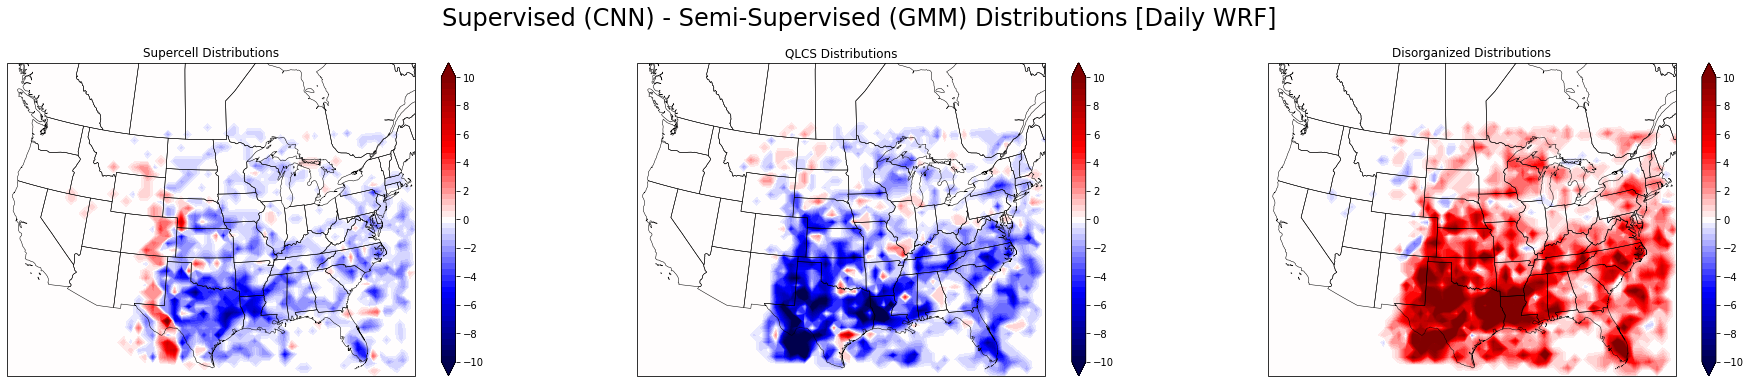

In [40]:
# Quick Sanity Check - Model Predictions

lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axes = plt.subplots(1, 3, figsize=(32, 6), subplot_kw=dict(projection=lc))
plt.subplots_adjust(top=0.85)
modes = ['Supercell', 'QLCS', 'Disorganized']
for i, ax in enumerate(axes.ravel()):
    mode = modes[i]
    data = (cnn_storms_daily_WRF[mode].sum(dim='time') - gmm_storms_daily_WRF[mode].sum(dim='time'))
    ax.set_extent([-120, -75, 25, 55], crs=ccrs.PlateCarree())
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    p = ax.contourf(gmm_storms_daily_WRF.lon, gmm_storms_daily_WRF.lat, data, levels=np.linspace(-10, 10, 50), transform=ccrs.PlateCarree(), cmap='seismic', extend='both')
    ax.set_title(f'{mode} Distributions')
    plt.colorbar(p, ax=ax, ticks=np.linspace(-10, 10, 11))
plt.suptitle('Supervised (CNN) - Semi-Supervised (GMM) Distributions [Daily WRF]', fontsize=24)
#plt.savefig('/glade/scratch/cbecker/CNN_GMM_dist_diff_daily_WRF.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.98, 'Semi-Supervised (HRRR) - Semi-Supervised (WRF)')

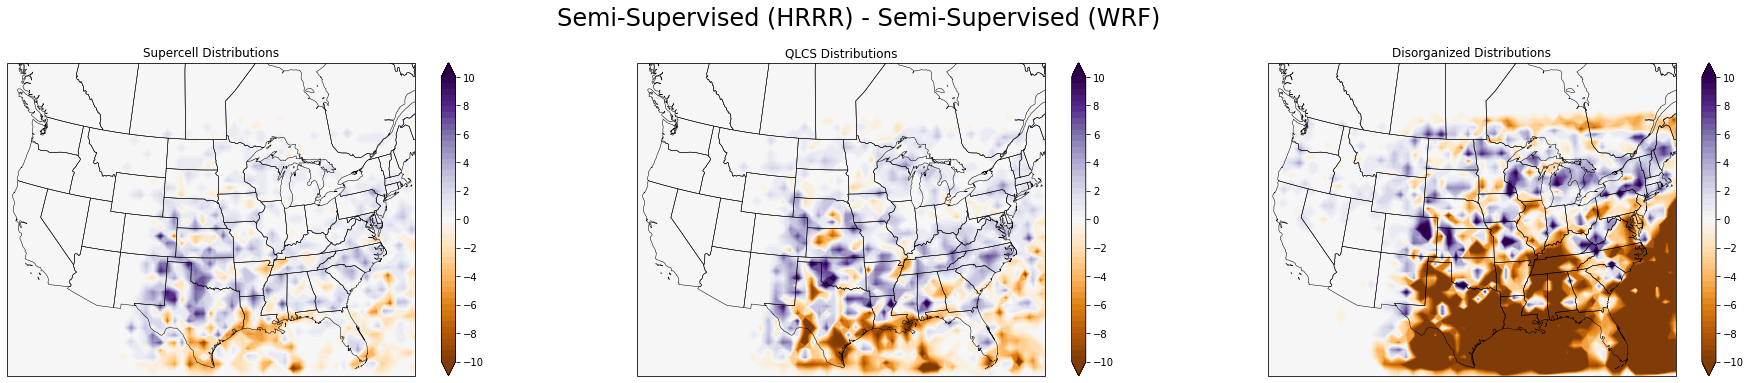

In [42]:
# Quick Sanity Check - Model Predictions

lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axes = plt.subplots(1, 3, figsize=(32, 6), subplot_kw=dict(projection=lc))
plt.subplots_adjust(top=0.85)
modes = ['Supercell', 'QLCS', 'Disorganized']
for i, ax in enumerate(axes.ravel()):
    mode = modes[i]
    data = (gmm_storms_daily_WRF[mode].sum(dim='time') - gmm_storms_daily[mode].sum(dim='time'))
    ax.set_extent([-120, -75, 25, 55], crs=ccrs.PlateCarree())
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    p = ax.contourf(gmm_storms_daily_WRF.lon, gmm_storms_daily_WRF.lat, data, levels=np.linspace(-10, 10, 50), transform=ccrs.PlateCarree(), cmap='PuOr', extend='both')
    ax.set_title(f'{mode} Distributions')
    plt.colorbar(p, ax=ax, ticks=np.linspace(-10, 10, 11))
plt.suptitle('Semi-Supervised (HRRR) - Semi-Supervised (WRF)', fontsize=24)
# plt.savefig('/glade/scratch/cbecker/GMM_WRF_HRRR_diff.png', dpi=300, bbox_inches='tight')

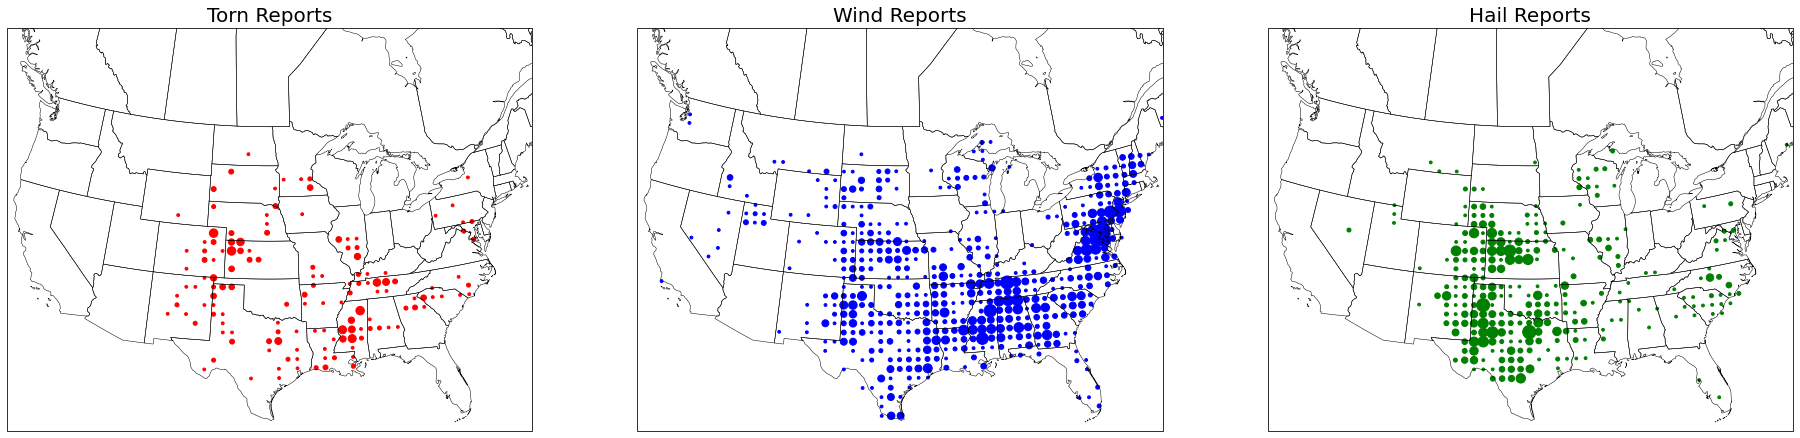

In [61]:
# Quick Sanity Check - Storm Observations

lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axes = plt.subplots(1, 3, figsize=(32, 22), subplot_kw=dict(projection=lc))
hazards = ['torn', 'wind', 'hail']
colors = ['r', 'b', 'g']
for i, ax in enumerate(axes.ravel()):
    hazard = hazards[i]
    data = obs[hazard].sum(dim='time')
    ax.set_extent([-120, -75, 25, 55], crs=ccrs.PlateCarree())
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.scatter(obs.lon, obs.lat, data*8, c=colors[i], transform=ccrs.PlateCarree())
    ax.set_title(f'{hazard.capitalize()} Reports', fontsize=20)
# plt.savefig('/glade/scratch/cbecker/HWT_Obs_reports.png', dpi=300, bbox_inches='tight')

In [47]:
# # obs.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_obs.nc')
# gmm_storms_daily.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_daily_rerun.nc')
# cnn_storms_daily.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_daily_rerun.nc')
# gmm_storms_hourly.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_hourly_rerun.nc')
# cnn_storms_hourly.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_hourly_rerun.nc')
# gmm_storms_daily_WRF.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_WRF_GMM_daily_rerun.nc')
# cnn_storms_daily_WRF.to_netcdf('/glade/scratch/cbecker/HWT_postproc/HWT_WRF_CNN_daily_rerun.nc')

In [7]:
obs = xr.open_dataset('/glade/scratch/cbecker/HWT_pHWT_obs.nc')
gmm_storms_daily = xr.open_dataset('/glade/scratch/cbecker/HWT_HRRR_GMM_daily.nc')
cnn_storms_daily = xr.open_dataset('/glade/scratch/cbecker/HWT_HRRR_CNN_daily.nc')
gmm_storms_hourly = xr.open_dataset('/glade/scratch/cbecker/HWT_HRRR_GMM_hourly.nc')
cnn_storms_hourly = xr.open_dataset('/glade/scratch/cbecker/HWT_HRRR_CNN_hourly.nc')
gmm_storms_daily_WRF = xr.open_dataset('/glade/scratch/cbecker/HWT_WRF_GMM_daily.nc')
cnn_storms_daily_WRF = xr.open_dataset('/glade/scratch/cbecker/HWT_WRF_CNN_daily.nc')

In [51]:
%%time 

# Date format = 'YYYMMDDhhmm'

NWP_model = 'HRRR'
start_date = '202104280000' 
end_date = '202106040000'
# label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
label_path = f'/glade/scratch/cbecker/HWT_HRRR_rerun/labels/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'
base_path = '/glade/scratch/cbecker/HWT_postproc/'

for thresh in np.arange(0.1, 1.0, 0.1):
    cnn_file = f'HWT_{NWP_model}_CNN_daily_thresh_{str(int(thresh*100))}_rerun.nc'
    gmm_file = f'HWT_{NWP_model}_GMM_daily_thresh_{str(int(thresh*100))}_rerun.nc'
    cnn = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 24, '1d', thresh)
    gmm = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 24, '1d', thresh)
    cnn.to_netcdf(join(base_path, cnn_file))
    gmm.to_netcdf(join(base_path, gmm_file))

CPU times: user 9min 23s, sys: 12.2 s, total: 9min 35s
Wall time: 9min 52s


In [54]:
%%time 

# Date format = 'YYYMMDDhhmm'

NWP_model = 'WRF'
start_date = '202104280000' 
end_date = '202106040000'
label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'
base_path = '/glade/scratch/cbecker/HWT_postproc/'

for thresh in np.arange(0.1, 1.0, 0.1):
    cnn_file = f'HWT_{NWP_model}_CNN_daily_thresh_{str(int(thresh*100))}_rerun.nc'
    gmm_file = f'HWT_{NWP_model}_GMM_daily_thresh_{str(int(thresh*100))}_rerun.nc'
    cnn = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 24, '1d', thresh)
    gmm = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 24, '1d', thresh)
    cnn.to_netcdf(join(base_path, cnn_file))
    gmm.to_netcdf(join(base_path, gmm_file))

CPU times: user 9min 52s, sys: 12.9 s, total: 10min 5s
Wall time: 10min 20s


In [58]:
%%time 

# Date format = 'YYYMMDDhhmm'

NWP_model = 'HRRR'
start_date = '202104280000' 
end_date = '202106040000'
# label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
label_path = f'/glade/scratch/cbecker/HWT_HRRR_rerun/labels/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'
base_path = '/glade/scratch/cbecker/HWT_postproc/'

for contour_level in [0.0001, 0.02, 0.05, 0.08, 0.11, 0.14, 0.17, 0.20]:
    cnn_file = f'HWT_{NWP_model}_CNN_daily_neighProb_{str(int(contour_level*100))}_rerun.nc'
    gmm_file = f'HWT_{NWP_model}_GMM_daily_neighProb_{str(int(contour_level*100))}_rerun.nc'
    cnn = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 24, '1d', thresh=None, contour_level=contour_level)
    gmm = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 24, '1d', thresh=None, contour_level=contour_level)
    cnn.to_netcdf(join(base_path, cnn_file))
    gmm.to_netcdf(join(base_path, gmm_file))

CPU times: user 8min 23s, sys: 10.6 s, total: 8min 34s
Wall time: 8min 55s


In [55]:
%%time 

# Date format = 'YYYMMDDhhmm'

NWP_model = 'WRF'
start_date = '202104280000' 
end_date = '202106040000'
label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'
base_path = '/glade/scratch/cbecker/HWT_postproc/'

for contour_level in [0.0001, 0.02, 0.05, 0.08, 0.11, 0.14, 0.17, 0.20]:
    cnn_file = f'HWT_{NWP_model}_CNN_daily_neighProb_{str(int(contour_level*100))}_rerun.nc'
    gmm_file = f'HWT_{NWP_model}_GMM_daily_neighProb_{str(int(contour_level*100))}_rerun.nc'
    cnn = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 24, '1d', thresh=None, contour_level=contour_level)
    gmm = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 24, '1d', thresh=None, contour_level=contour_level)
    cnn.to_netcdf(join(base_path, cnn_file))
    gmm.to_netcdf(join(base_path, gmm_file))

CPU times: user 8min 46s, sys: 11.6 s, total: 8min 57s
Wall time: 9min 4s


In [3]:
%%time 

# Date format = 'YYYMMDDhhmm'

NWP_model = 'HRRR'
start_date = '202104280000' 
end_date = '202106040000'
label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'
base_path = '/glade/scratch/cbecker/HWT_postproc/'

for thresh in np.arange(0.1, 1.0, 0.1):
    cnn_file = f'HWT_{NWP_model}_CNN_hourly_thresh_{str(int(thresh*100))}_rerun.nc'
    gmm_file = f'HWT_{NWP_model}_GMM_hourly_thresh_{str(int(thresh*100))}_rerun.nc'
    cnn = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 18, '1h', thresh)
    gmm = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 18, '1h', thresh)
    cnn.to_netcdf(join(base_path, cnn_file))
    gmm.to_netcdf(join(base_path, gmm_file))

/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0600.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0700.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0800.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0900.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1000.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1100.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1200.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1300.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/lab

In [4]:
%%time 

# Date format = 'YYYMMDDhhmm'

NWP_model = 'HRRR'
start_date = '202104280000' 
end_date = '202106040000'
label_path = f'/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/{NWP_model}/'
storm_report_path = '/glade/scratch/cbecker/HWT_2021_storm_reports/'
model_grid_path = '/glade/scratch/cbecker/grids/NCEP_211_grid.nc'
base_path = '/glade/scratch/cbecker/HWT_postproc/'

for contour_level in [0.0001, 0.02, 0.05, 0.08, 0.11, 0.14, 0.17, 0.20]:
    cnn_file = f'HWT_{NWP_model}_CNN_hourly_neighProb_{str(int(contour_level*100))}.nc'
    gmm_file = f'HWT_{NWP_model}_GMM_hourly_neighProb_{str(int(contour_level*100))}.nc'
    cnn = generate_storm_grid(start_date, end_date, label_path, 'cnn_test_000', model_grid_path, 1, 18, '1h', thresh=None, contour_level=contour_level)
    gmm = generate_storm_grid(start_date, end_date, label_path, 'mod_0', model_grid_path, 1, 18, '1h', thresh=None, contour_level=contour_level)
    cnn.to_netcdf(join(base_path, cnn_file))
    gmm.to_netcdf(join(base_path, gmm_file))

/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0600.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0700.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0800.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-0900.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1000.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1100.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1200.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/labels/HRRR/cnn_test_000_labels_20210427-1300.pkl doesn't seem to exist. Skipping.
/glade/p/cisl/aiml/hwt_mode/HWT_2021/lab